# Example 1

Trying out the example codes in https://github.com/marinkaz/scikit-fusion

In [7]:
import pylab as plt
import matplotlib
from IPython.display import display, HTML

import numpy as np
import pandas as pd
from skfusion import fusion

%matplotlib inline

In [8]:
R12 = np.random.rand(50, 100)
R13 = np.random.rand(50, 40)
R23 = np.random.rand(100, 40)

In [9]:
t1 = fusion.ObjectType('Type 1', 10)
t2 = fusion.ObjectType('Type 2', 20)
t3 = fusion.ObjectType('Type 3', 30)
relations = [fusion.Relation(R12, t1, t2),
             fusion.Relation(R13, t1, t3),
             fusion.Relation(R23, t2, t3)]
fusion_graph = fusion.FusionGraph()
fusion_graph.add_relations_from(relations)

In [10]:
fuser = fusion.Dfmf()
fuser.fuse(fusion_graph)

Dfmf(stopping_system=None, n_jobs=1, verbose=0, init_type=random_c, max_iter=100, compute_err=False, callback=None, random_state=None, stopping=None, n_run=1)

(50, 10)


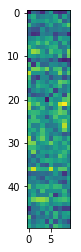

In [11]:
m1 = fuser.factor(t1)
print m1.shape
plt.imshow(m1)

(100, 20)


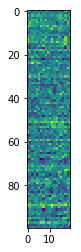

In [12]:
m2 = fuser.factor(t2)
print m2.shape
plt.imshow(m2)

In [14]:
from skfusion import datasets

In [15]:
pharma = datasets.load_pharma()
action = pharma.get_object_type('Action')
pmid = pharma.get_object_type('PMID')
depositor = pharma.get_object_type('Depositor')
fingerprint = pharma.get_object_type('Fingerprint')
depo_cat = pharma.get_object_type('Depositor category')
chemical = pharma.get_object_type('Chemical')

In [17]:
type(pharma)

skfusion.fusion.base.fusion_graph.FusionGraph

In [18]:
action = pharma.get_object_type('Action')

In [20]:
pharma.relations

OrderedDict([(Relation(ObjectType("Chemical") → ObjectType("Action")), True),
             (Relation(ObjectType("Chemical") → ObjectType("PMID")), True),
             (Relation(ObjectType("Chemical") → ObjectType("Depositor")),
              True),
             (Relation(ObjectType("Chemical") → ObjectType("Fingerprint")),
              True),
             (Relation(ObjectType("Depositor") → ObjectType("Depositor category")),
              True),
             (Relation(ObjectType("Chemical") → ObjectType("Chemical")),
              True)])

# Example 2

More example codes from https://github.com/marinkaz/scikit-fusion/blob/master/examples/dicty_association.py

Fusion of three data sources for gene function prediction in Dictyostelium

Fuse three data sets: gene expression data (Miranda et al., 2013, PLoS One),
slim gene annotations from Gene Ontology and protein-protein interaction
network from STRING database.

Learnt latent matrix factors are utilized for the prediction of slim GO
terms in Dictyostelium genes that are unavailable in the training phase.
This example demonstrates how latent matrices estimated by data fusion
can be utilized for association prediction.

In [12]:
from sklearn import cross_validation, metrics
import numpy as np

from skfusion import datasets
from skfusion import fusion as skf

/Users/joewandy/anaconda/envs/omics/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [13]:
dicty = datasets.load_dicty()
gene = dicty.get_object_type("Gene")
go_term = dicty.get_object_type("GO term")
exp_cond = dicty.get_object_type("Experimental condition")

In [19]:
print(dicty)

FusionGraph(Object types: 3, Relations: 3)


In [20]:
print(dicty.object_types)

OrderedDict([(ObjectType("Gene"), True), (ObjectType("GO term"), True), (ObjectType("Experimental condition"), True)])


In [21]:
print(dicty.relations)

OrderedDict([(Relation(ObjectType("Gene") "ann" ObjectType("GO term")), True), (Relation(ObjectType("Gene") "expr" ObjectType("Experimental condition")), True), (Relation(ObjectType("Gene") "ppi" ObjectType("Gene")), True)])


In [14]:
n_folds = 10
n_genes = dicty[gene][go_term][0].data.shape[0]
cv = cross_validation.KFold(n_genes, n_folds=n_folds)
fold_mse = np.zeros(n_folds)
ann_mask = np.zeros_like(dicty[gene][go_term][0].data).astype('bool')

In [15]:
relations = [
    skf.Relation(dicty[gene][go_term][0].data, gene, go_term),
    skf.Relation(dicty[gene][exp_cond][0].data, gene, exp_cond),
    skf.Relation(dicty[gene][gene][0].data, gene, gene)]
fusion_graph = skf.FusionGraph(relations)
fuser = skf.Dfmc(max_iter=30, n_run=1, init_type='random', random_state=0)

In [16]:
for i, (train_idx, test_idx) in enumerate(cv):
    ann_mask[:] = False
    ann_mask[test_idx, :] = True
    fusion_graph[gene][go_term][0].mask = ann_mask

    fuser.fuse(fusion_graph)
    pred_ann = fuser.complete(fuser.fusion_graph[gene][go_term][0])[test_idx]
    true_ann = dicty[gene][go_term][0].data[test_idx]
    fold_mse[i] = metrics.mean_squared_error(pred_ann, true_ann)

print("MSE: %5.4f" % np.mean(fold_mse))

MSE: 0.0389
